In [197]:
import ltspice 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np 
import os  
from PyLTSpice.LTSpice_RawRead import LTSpiceRawRead
import pandas as pd
from os import listdir
import sys
from scipy import interpolate 
from scipy.optimize import curve_fit
import scipy.constants as cons
import h5py
import matplotlib.ticker as ticker
from datetime import datetime
from scipy import asarray as ar,exp
from scipy.signal import savgol_filter

Definitions

In [198]:
atomic_mass =  1.66053906660* 10**(-27)
m_Ca = (39.96259087)*atomic_mass
##
## Simulation values of Electric fields due to 1V on electrodes 
##

x_axis =[1.26283104e-02 , 2.84553925e-03, -1.73513234e-01, -2.33007065e+02, 2.31467575e+02, 6.34518683e-01, 8.86796176e-01,
-5.73204041e+01, 5.68283157e+01, 1.36016592e-01, 1.57674611e-01]

y_axis = [3.244789123535156250e+01,-3.232956314086914062e+01, -7.539201974868774414e-01, -2.477783896028995514e-02, -7.491269707679748535e-02, 5.387742309570312500e+02, -5.378519897460937500e+02,7.722367998212575912e-03, -3.334570792503654957e-04, 6.302957763671875000e+02, -6.301546630859375000e+02]

z_axis = [-1.459924411773681641e+01,-1.447677612304687500e+01,7.160206909179687500e+02,1.169928665161132812e+02,1.169021453857421875e+02,4.762999267578125000e+02,4.743959350585937500e+02,-1.385639762878417969e+01,-1.369526290893554688e+01,-9.236360473632812500e+02,-9.233392944335937500e+02]


#x_axis =[1.26283104e-02 , 2.84553925e-03, -1.73513234e-01, -2.33007065e+02, 2.31467575e+02, 6.34518683e-01, 8.86796176e-01,
#-5.73204041e+01, 5.68283157e+01,0.29369120299999996]

#y_axis = [3.244789123535156250e+01,-3.232956314086914062e+01, -7.539201974868774414e-01, -2.477783896028995514e-02, -7.491269707679748535e-02, 5.387742309570312500e+02, -5.378519897460937500e+02,7.722367998212575912e-03, -3.334570792503654957e-04,0.14111328125]

#z_axis = [-1.459924411773681641e+01,-1.447677612304687500e+01,7.160206909179687500e+02,1.169928665161132812e+02,1.169021453857421875e+02,4.762999267578125000e+02,4.743959350585937500e+02,-1.385639762878417969e+01,-1.369526290893554688e+01,-1846.975341796875]
Voltage_Set = [8.16, -9.04,  -1.07 , 5.29 , 5.29 ,0.24 ,1.28 ,4.91 ,4.91 ,0.58 ,0.58]
"""Voltage_Set = {'elec_2a': 8.16, 
  'elec_2b': -9.04, 
  'elec_a': -1.07 ,
  'elec_b1': 5.29 ,
  'elec_b2': 5.29 ,
  'elec_1a': 0.24 ,
  'elec_1b': 1.28 ,
  'elec_c1': 4.91 ,
  'elec_c2': 4.91 ,
  'elec_T1': 0.58 ,
  'elec_T2': 0.58}
"""

"Voltage_Set = {'elec_2a': 8.16, \n  'elec_2b': -9.04, \n  'elec_a': -1.07 ,\n  'elec_b1': 5.29 ,\n  'elec_b2': 5.29 ,\n  'elec_1a': 0.24 ,\n  'elec_1b': 1.28 ,\n  'elec_c1': 4.91 ,\n  'elec_c2': 4.91 ,\n  'elec_T1': 0.58 ,\n  'elec_T2': 0.58}\n"

Functions

In [199]:
def squared(x):
    return(x**2)

def SpectralNoiseFormula(sdAmplf, sdAllpass ,gainAllpass):
    s_tot = (sdAmplf**2)*(gainAllpass**2) + (sdAllpass**2)
    return  s_tot 

def sqrtSpectralNoiseFormula(sdAmplf, sdAllpass ,gainAllpass):
    s_tot = ((sdAmplf**2)*(gainAllpass**2) + (sdAllpass**2))**(1/2)
    return  s_tot 
    
def conversion(valuedBm): 
    rbw = 100
    impedance = 50
    a = np.sqrt((impedance*0.001/rbw)*(10**((valuedBm+10)/10)))  
    return a

def conversioncorrect(valuedBm): 
    rbw = 100
    impedance = 50
    a = np.sqrt((impedance*0.001/rbw)*(10**((valuedBm)/10)))  
    return a

In [200]:
rawFB = ltspice.Ltspice('actualfilter.raw')
rawFBfeed = ltspice.Ltspice('actualfilterfeedthru.raw')
rawFB.parse()
rawFBfeed.parse()


#FB at Trap 
noise_rawFB = rawFB.get_data('V(onoise)')
gain_rawFB = rawFB.get_data('gain')
freq = rawFB.get_data('frequency')

#FB at Feedthru
noise_rawFBfeed = rawFBfeed.get_data('V(onoise)')
gain_rawFBfeed = rawFBfeed.get_data('gain')
freq = rawFBfeed.get_data('frequency')



Plot

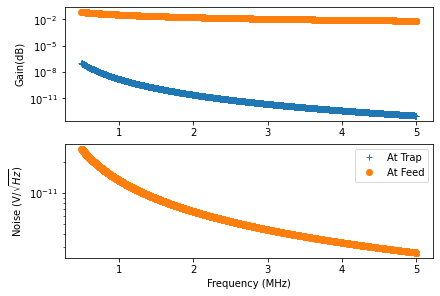

In [201]:
fig, ax = plt.subplots(2, constrained_layout=True)
ax[0].semilogy(freq, gain_rawFB,'+' ,label = 'At Trap')
ax[1].semilogy(freq, noise_rawFB,'+' ,label = 'At Trap')
ax[0].semilogy(freq, gain_rawFBfeed,'o', label = 'At Feed')
ax[1].semilogy(freq, noise_rawFBfeed,'o' ,label = 'At Feed')

ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10**(-6)))
ax[0].xaxis.set_major_formatter(ticks)
ax[1].xaxis.set_major_formatter(ticks)
#plt.yscale('log',base=10) 

#ax[0].set_title('Gain')
ax[0].set_ylabel('Gain(dB)')
#ax[1].set_title('Noise')
ax[1].set_xlabel('Frequency (MHz)')
ax[1].set_ylabel('Noise (V/$\sqrt{Hz}$)')

plt.legend()
plt.show()



Total Noise


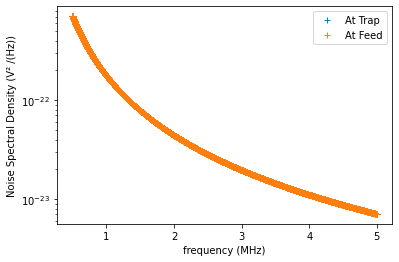

In [202]:
frequency_array = []
Noise_fb = []
Noise_fbfeed = []
for j in range(0, len(freq)): 
    frequency = freq[j]
    frequency_array.append(frequency) 
    Noise_fb.append(squared(noise_rawFB[j]))
    Noise_fbfeed.append(squared(noise_rawFBfeed[j]))

fig, ax = plt.subplots()
ax.plot(frequency_array,  Noise_fb, '+',label="At Trap")
ax.plot(frequency_array,  Noise_fbfeed, '+',label="At Feed")
ax.set_xlabel('frequency (MHz)')
ax.set_ylabel('Noise Spectral Density (V\u00b2 /(Hz))')
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10**(-6)))
ax.xaxis.set_major_formatter(ticks)
plt.yscale('log',base=10) 
plt.legend()
plt.show()


Heating Rate Conversion

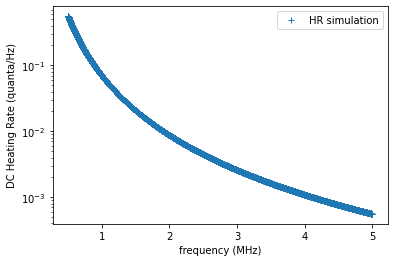

In [203]:
SE_allelec_sim = []
heating_rates_sim = []


## conversion
def SEcalc1axs1elec(Volt_sd, V_E_scaling):
    return Volt_sd * (V_E_scaling)**(2)

for i in range(0, len(frequency_array)):
    summe_y = 0
    for j in range(len(z_axis)):
        summe_y += SEcalc1axs1elec( Noise_fb[i],z_axis[j])
        #firstelec = SEcalc1axs1elec(Noise[i],y_axis[4]) + SEcalc1axs1elec(Noise[i],y_axis[5]) + SEcalc1axs1elec(Noise[i],y_axis[6])
    SE_allelec_sim.append(summe_y)    


for k in range(0, len(frequency_array)):

    heating_x = ((cons.e)**2 * SE_allelec_sim[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array[k])
   

    heating_rates_sim.append(heating_x)

## Plotting Data 

fig, ax = plt.subplots()

ax.plot(frequency_array, heating_rates_sim,'+' ,label='HR simulation')
#ax.plot(sp["frequency"], heating_rates_1elec, 'm+', label='HR 1elecetrode')
ax.set_xlabel('frequency (MHz)')
ax.set_ylabel('DC Heating Rate (quanta/Hz)')
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10**(-6)))
ax.xaxis.set_major_formatter(ticks)
plt.yscale('log',base=10) 
plt.legend()
plt.show()

WITH Measurements

In [204]:

rawFBfeed = ltspice.Ltspice('actualfilterfeedthru.raw')
rawFBfeed.parse()
#FB at Feedthru
noise_rawFBfeed = rawFBfeed.get_data('V(onoise)')
gain_rawFBfeed = rawFBfeed.get_data('gain')
freq = rawFBfeed.get_data('frequency')


In [205]:
frequency_x = np.array([0.9001789823391073,
0.9437795729477444,
1.0252114885676957,
1.0638987887232565,
1.100821295451343,
1.135977488147777,
1.236995745603602,
1.267927434665372,
1.2996137379209354,
1.3586571602600996,
1.415701554619007])
frequency_x = frequency_x*1.e6
HR_x = [69.24038869733933,
59.96234042377333,
47.2138851604604,
46.87063426697047,
37.475966505562255,
39.00563001250567,
31.281636157386867,
31.808799176921827,
27.730829872254766,
26.928522292376087,
21.589198655440015]
frequency_y =np.array([1.636717664073176,
1.7536338634632855,
1.8203482753879003,
1.8779897626938327,
1.9564506050049877,
2.017706938996064,
2.059106057300692,
2.0685732477088816,
2.1263569835276694,
2.131024608733191,
2.1777966511759748,
2.2606404448466964,
2.264803303855524,
2.3094745527924125,
2.3281001503012906,
2.36837062575528,
2.3849040793683076,
2.510028803327298,
2.5699035468931064,
2.6503880938410074,
2.656269565447679,
2.676090733502241,
2.712717466840009,
2.786931815957286,
2.8008107026471483,
2.8546191443380193,
2.941854418671944,
3.1005188732475477,
3.1030324705203385,
3.1775296269353306,
3.258474391947965,
3.2683624563390397])
frequency_y = frequency_y*1.e6
HR_y = [83.1316978538842,
87.1181096291914,
96.74398456185432,
98.05476403643297,
317.32366620027733,
184.53757871196763,
89.84257107969407,
127.15788475447035,
63.53830073478075,
63.643521576931846,
101.92438891901317,
144.53381830750342,
108.79548718749002,
40.88811015418392,
93.67572781724047,
40.6244462378223,
61.72556842189231,
44.93652605958764,
39.547346977122494,
29.256747851191978,
22.094067716037976,
23.018262555123087,
47.767145589454685,
31.405541907047905,
37.38933429187226,
49.175929249922696,
26.369913258807475,
27.22494199890959,
19.151001987434437,
25.57834629527803,
29.89083016253065,
15.238538324671833]
frequency_z = np.array([ 1.3006531228324631,
1.4219998106805296,
1.528808904028959,
1.529038593885789,
1.6222867469610052,
1.6526144143251333,
1.6716286167317251,
1.7354391725138367,
1.7534472255609748,
1.7862289383704435,
1.813798119863976,
1.8661076549427857,
1.8976857082214083,
1.9511326528103774,
2.014522358507832,
2.018349014787159,
2.085631569092366,
2.1197646193723507,
2.143368791558399,
2.167159695408431,
2.22902072210736,
2.299057617348615,
2.3062992387009165,
2.3691792467435486,
2.4523265691277363,
2.4598293211825086,
2.4784592798352842,
2.5201431695313983,
2.5996644217703304,
2.614229943490361,
2.674374926568465,
2.763042218359706,
2.7706925100325894,
2.849412255065737,
2.931007955353169,
2.931931383238576,
3.0122735535852994,
3.0964691255211214,
3.1060919441834898 ])
frequency_z = frequency_z*1.e6
HR_z = [530.1174631931104,
148.96534086729986,
142.1574966038835,
215.66264929298882,
162.80523487069573,
151.43439004659754,
149.82375034292608,
225.8380211737235,
268.3532552385673,
261.4922082743787,
448.10381245925356,
114.14022557165268,
207.96595022296438,
271.6804507964738,
265.81229657232694,
291.2934618390539,
159.80109896106026,
209.86404562850345,
178.04778145324485,
192.28289681582436,
231.68656211013186,
136.27946983090325,
168.7843622674747,
288.9218416924599,
162.87755055013187,
127.74672490746997,
158.21131280390307,
87.3006801872009,
66.6793027541329,
97.72298669444105,
61.037860461430995,
75.01722966537993,
49.0495081906319,
150.88086399682203,
67.6944393534121,
87.19541684492229,
62.67221240699694,
41.830974475958676,
28.328439593766962]

In [206]:
folder_path = "/Users/aidamashaal/Desktop/"
chasis = pd.read_csv(folder_path +"chasis",delimiter = "\t")
fb = pd.read_csv(folder_path +"fb_orig",delimiter = "\t")
fb_noavg = pd.read_csv("fb_noavg",delimiter = "\t")
Dac = pd.read_csv("Dac",delimiter = "\t")
#Dac = pd.read_csv(folder_path + "Dac.csv",delimiter = "\t")  
gnd = pd.read_csv("gnd",delimiter = "\t")  
chasis_converted =[]
dac_converted = []
gnd_converted = []
fb_converted = []
fb_noavg_converted = []
frequency_array_meas = []
 

feq_meas = np.array(list(fb_noavg.iloc[:,0])) # np.array(list(chasis.iloc[:,0]))
chasis_mag = list(chasis.iloc[:,1])
fb_mag = list(fb.iloc[:,1])
fb_noavg_mag = list(fb_noavg.iloc[:,1])
dac_mag = list(Dac.iloc[:,1])
gnd_mag = list(gnd.iloc[:,1])
for i in range(0, len(feq_meas)):
    chasis_converted.append(conversion(chasis_mag[i]))
    fb_converted.append(conversion(fb_mag[i]))
    fb_noavg_converted.append(conversioncorrect(fb_noavg_mag[i]))
    dac_converted.append(conversioncorrect(dac_mag[i]))
    gnd_converted.append(conversioncorrect(gnd_mag[i]))


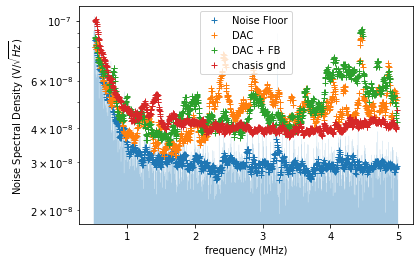

In [207]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

fig, ax = plt.subplots()

ax.plot(moving_average(feq_meas, 10), moving_average(gnd_converted, 10),'+' ,label='Noise Floor')
ax.fill_between(feq_meas, gnd_converted,step="pre", alpha=0.4)

ax.plot(moving_average(feq_meas,10), moving_average(dac_converted,10), '+',label='DAC')
ax.plot(moving_average(feq_meas,10), moving_average(fb_noavg_converted,10), '+',label='DAC + FB')
ax.plot(moving_average(feq_meas,10),moving_average(chasis_converted,10), '+',label="chasis gnd")
ax.set_xlabel('frequency (MHz)')
ax.set_ylabel('Noise Spectral Density (V/$\sqrt{Hz}$)')
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10**(-6)))
ax.xaxis.set_major_formatter(ticks)
plt.yscale('log',base=10) 
plt.legend()
plt.show()

No handles with labels found to put in legend.


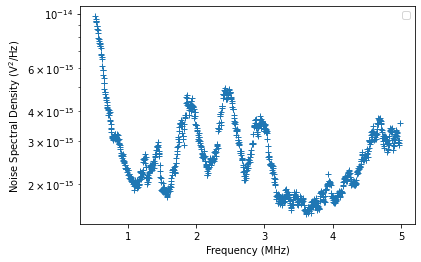

In [208]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

fig, ax = plt.subplots()
fb_converted = np.array(fb_converted)
fb_converted1 = fb_converted**(2)
ax.plot(moving_average(feq_meas,10), moving_average(fb_converted1,10), '+')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Noise Spectral Density (V$^{2}$/Hz)')
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10**(-6)))
ax.xaxis.set_major_formatter(ticks)
plt.yscale('log',base=10) 
plt.legend()
plt.show()

In [209]:
chasis_noise = []
fb_noise = []
Dac_noise = []
fb_noisenotft = []
fb_noavg_noise = []
gnd_noise = []

for j in range(0, len(feq_meas)): 
    frequency_meas = feq_meas[j]
    frequency_array_meas.append(frequency_meas) 
    noise_interpolated = np.interp(frequency_meas, freq, noise_rawFBfeed)
    gain_interpolated = np.interp(frequency_meas, freq, gain_rawFBfeed)
    noisefull_interpolated = np.interp(frequency_meas, freq, noise_rawFB)
    gainfull_interpolated = np.interp(frequency_meas, freq, gain_rawFB)

    chasis_noise.append(SpectralNoiseFormula(chasis_converted[j],noise_interpolated,gain_interpolated))
    fb_noise.append(SpectralNoiseFormula(fb_converted[j],noise_interpolated,gain_interpolated))
    fb_noavg_noise.append(SpectralNoiseFormula(fb_noavg_converted[j],noise_interpolated,gain_interpolated))
    fb_noisenotft.append(squared(fb_converted[j]))
    #Dac_noise.append(SpectralNoiseFormula(chasis_converted[j],noisefull_interpolated,gainfull_interpolated))
    Dac_noise.append(SpectralNoiseFormula(dac_converted[j],noise_interpolated,gain_interpolated))
    gnd_noise.append(SpectralNoiseFormula(gnd_converted[j],noise_interpolated,gain_interpolated))



In [60]:
#modified for pres
chasis_noise = []
fb_noise = []
Dac_noise = []
fb_noisenotft = []
fb_noavg_noise = []
gnd_noise = []

for j in range(0, len(feq_meas)): 
    frequency_meas = feq_meas[j]
    frequency_array_meas.append(frequency_meas) 
    noise_interpolated = np.interp(frequency_meas, freq, noise_rawFBfeed)
    gain_interpolated = np.interp(frequency_meas, freq, gain_rawFBfeed)
    noisefull_interpolated = np.interp(frequency_meas, freq, noise_rawFB)
    gainfull_interpolated = np.interp(frequency_meas, freq, gain_rawFB)

    #chasis_noise.append(SpectralNoiseFormula(chasis_converted[j],noise_interpolated,gain_interpolated))
    fb_noise.append(SpectralNoiseFormula(fb_converted[j],noise_interpolated,gain_interpolated))
   
    #fb_noavg_noise.append(SpectralNoiseFormula(fb_noavg_converted[j],noise_interpolated,gain_interpolated))
    #fb_noisenotft.append(squared(fb_converted[j]))
    #Dac_noise.append(SpectralNoiseFormula(chasis_converted[j],noisefull_interpolated,gainfull_interpolated))
    Dac_noise.append(SpectralNoiseFormula(dac_converted[j],noise_interpolated,gain_interpolated))
    #gnd_noise.append(SpectralNoiseFormula(gnd_converted[j],noise_interpolated,gain_interpolated))
#fb_noise = np.array(fb_noise)

#fb_noise = 10* fb_noise

In [ ]:

fig, ax = plt.subplots()

ax.plot(frequency_array_meas,Dac_noise, '+',label='Simulation')
ax.plot(frequency_array_meas, fb_noise, '+',label='Measured')

ax.set_xlabel('frequency (MHz)')
ax.set_ylabel('Noise Spectral Density (V\ub002 /Hz$)')
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10**(-6)))
ax.xaxis.set_major_formatter(ticks)
plt.yscale('log',base=10) 
plt.legend()
plt.show()

In [62]:
0.5*2*np.pi

3.141592653589793

In [146]:
##change center
#x_axis =[ 3.24501152e+01,-3.23324051e+01,-5.91082036e-01, -3.08000557e-02, -5.74545898e-02, 5.38617737e+02, -5.37763794e+02, 6.00837404e-03, -5.35389918e-05, 6.30306091e+02,-6.30144287e+02]


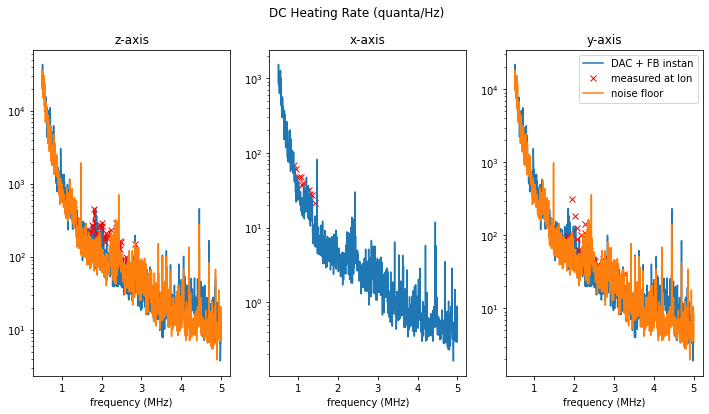

In [210]:
SE_meas_z = []
heating_rates_meas_z = []
SE_meas_x = []
heating_rates_meas_x = []
SE_meas_y = []
heating_rates_meas_y = []

SE_gnd_meas_z = []
heating_rates_gnd_meas_z = []
SE_gnd_meas_x = []
heating_rates_gnd_meas_x = []
SE_gnd_meas_y = []
heating_rates_gnd_meas_y = []


SE_measfb_z = []
heating_rates_measfb_z = []
SE_measfb_x = []
heating_rates_measfb_x = []
SE_measfb_y = []
heating_rates_measfb_y = []

SE_measfb_noavg_z = []
heating_rates_measfb_noavg_z = []
SE_measfb_noavg_x = []
heating_rates_measfb_noavg_x = []
SE_measfb_noavg_y = []
heating_rates_measfb_noavg_y = []


SE_measdac_z = []
heating_rates_measdac_z = []
SE_measdac_x = []
heating_rates_measdac_x = []
SE_measdac_y = []
heating_rates_measdac_y = []


## conversion
def SEcalc1axs1elec(Volt_sd, V_E_scaling):
    return Volt_sd *(V_E_scaling)**(2)

for i in range(0, len(frequency_array_meas)):
    z_summe_ch = 0
    z_summe_gnd = 0
    z_summe_fb = 0
    z_summe_dac= 0
    z_summe_fbnoavg= 0

    x_summe_ch = 0
    x_summe_fb = 0
    x_summe_gnd = 0
    x_summe_dac= 0
    x_summe_fbnoavg= 0

    y_summe_ch = 0
    y_summe_fb = 0
    y_summe_dac= 0
    y_summe_gnd = 0
    y_summe_fbnoavg= 0


    for j in range(len(z_axis)):
        z_summe_ch += SEcalc1axs1elec(chasis_noise[i],z_axis[j])
        z_summe_fb += SEcalc1axs1elec(fb_noise[i],z_axis[j])
        z_summe_dac += SEcalc1axs1elec(Dac_noise[i],z_axis[j])
        z_summe_fbnoavg += SEcalc1axs1elec(fb_noavg_noise[i],z_axis[j])
        z_summe_gnd += SEcalc1axs1elec(gnd_noise[i],z_axis[j])
        #firstelec = SEcalc1axs1elec(Noise[i],y_axis[4]) + SEcalc1axs1elec(Noise[i],y_axis[5]) + SEcalc1axs1elec(Noise[i],y_axis[6])

        x_summe_ch += SEcalc1axs1elec(chasis_noise[i],x_axis[j])
        x_summe_fb += SEcalc1axs1elec(fb_noise[i],x_axis[j])
        x_summe_dac += SEcalc1axs1elec(Dac_noise[i],x_axis[j])
        x_summe_fbnoavg += SEcalc1axs1elec(fb_noavg_noise[i],x_axis[j])
        x_summe_gnd += SEcalc1axs1elec(gnd_noise[i],x_axis[j])

        y_summe_ch += SEcalc1axs1elec(chasis_noise[i],y_axis[j])
        y_summe_fb += SEcalc1axs1elec(fb_noise[i],y_axis[j])
        y_summe_dac += SEcalc1axs1elec(Dac_noise[i],y_axis[j])
        y_summe_fbnoavg += SEcalc1axs1elec(fb_noavg_noise[i],y_axis[j])
        y_summe_gnd += SEcalc1axs1elec(gnd_noise[i],y_axis[j])


    SE_meas_z.append(z_summe_ch)
    SE_meas_x.append(x_summe_ch)  
    SE_meas_y.append(y_summe_ch)   

    SE_measfb_z.append(z_summe_fb)
    SE_measfb_x.append(x_summe_fb)  
    SE_measfb_y.append(y_summe_fb)     

    SE_measdac_z.append(z_summe_dac)
    SE_measdac_x.append(x_summe_dac)  
    SE_measdac_y.append(y_summe_dac)   

    SE_measfb_noavg_z.append(z_summe_fbnoavg) 
    SE_measfb_noavg_x.append(x_summe_fbnoavg) 
    SE_measfb_noavg_y.append(y_summe_fbnoavg) 


    SE_gnd_meas_z.append(z_summe_gnd) 
    SE_gnd_meas_x.append(x_summe_gnd) 
    SE_gnd_meas_y.append(y_summe_gnd) 


for k in range(0, len(frequency_array_meas)):

    heating_meas_z = ((cons.e)**2 * SE_meas_z[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heating_meas_x = ((cons.e)**2 * SE_meas_x[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heating_meas_y = ((cons.e)**2 * SE_meas_y[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])


    heatingfb_meas_z = ((cons.e)**2  *SE_measfb_z[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatingfb_meas_x = ((cons.e)**2  *SE_measfb_x[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatingfb_meas_y = ((cons.e)**2  *SE_measfb_y[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])

    heatingfb_noavg_meas_z = ((cons.e)**2 * SE_measfb_noavg_z[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatingfb_noavg_meas_x = ((cons.e)**2 * SE_measfb_noavg_x[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatingfb_noavg_meas_y = ((cons.e)**2 * SE_measfb_noavg_y[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])


    heatingdac_meas_z = ((cons.e)**2 * SE_measdac_z[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatingdac_meas_x = ((cons.e)**2 * SE_measdac_x[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatingdac_meas_y = ((cons.e)**2 * SE_measdac_y[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])


    heatinggnd_meas_z = ((cons.e)**2 * SE_gnd_meas_z[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatinggnd_meas_x = ((cons.e)**2 * SE_gnd_meas_x[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatinggnd_meas_y = ((cons.e)**2 * SE_gnd_meas_y[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])


    heating_rates_meas_z.append(heating_meas_z)
    heating_rates_meas_x.append(heating_meas_x)
    heating_rates_meas_y.append(heating_meas_y)

    heating_rates_measfb_z.append(heatingfb_meas_z)
    heating_rates_measfb_x.append(heatingfb_meas_x)
    heating_rates_measfb_y.append(heatingfb_meas_y)

    heating_rates_measdac_z.append(heatingdac_meas_z)
    heating_rates_measdac_x.append(heatingdac_meas_x)
    heating_rates_measdac_y.append(heatingdac_meas_y)

    heating_rates_measfb_noavg_z.append(heatingfb_noavg_meas_z)
    heating_rates_measfb_noavg_x.append(heatingfb_noavg_meas_x)
    heating_rates_measfb_noavg_y.append(heatingfb_noavg_meas_y)

    heating_rates_gnd_meas_z.append(heatinggnd_meas_z)
    heating_rates_gnd_meas_x.append(heatinggnd_meas_x)
    heating_rates_gnd_meas_y.append(heatinggnd_meas_y)    

## Plotting Data 

fig, ax = plt.subplots(1,3, figsize=(12,6))

#ax[0].semilogy(frequency_array_meas, heating_rates_meas_z, label ='DAC + fb grounded')
ax[0].semilogy(frequency_array_meas, heating_rates_measfb_noavg_z,label ='DAC + FB instan')
#ax[0].semilogy(frequency_array_meas, heating_rates_measfb_z, label ='DAC + FB')
ax[0].semilogy(frequency_z, HR_z, label ='measured at Ion', linestyle = '--', marker = 'x', color = 'r')
ax[0].semilogy(frequency_array_meas, heating_rates_measdac_z ,label ='noise floor')
ax[0].set_title('z-axis')
#ax[1].semilogy(frequency_array_meas, heating_rates_meas_x, label ='DAC + fb grounded')
#ax[1].semilogy(frequency_array_meas, heating_rates_measfb_noavg_x,label ='DAC + FB instan')
#ax[1].semilogy(frequency_array_meas, heating_rates_measfb_x, label ='DAC + FB')
ax[1].semilogy(frequency_x, HR_x, label ='measured at Ion', linestyle = '', marker = 'x', color = 'r')
ax[1].semilogy(frequency_array_meas, heating_rates_measdac_x, label ='noise floor')
ax[1].set_title('x-axis')

#ax[2].semilogy(frequency_array_meas, heating_rates_meas_y, label ='DAC + fb grounded')
ax[2].semilogy(frequency_array_meas, heating_rates_measfb_noavg_y,label ='DAC + FB instan')
#ax[2].semilogy(frequency_array_meas, heating_rates_measfb_y, label ='DAC + FB')
ax[2].semilogy(frequency_y, HR_y, label ='measured at Ion', linestyle = '', marker = 'x', color = 'r')
ax[2].semilogy(frequency_array_meas, heating_rates_measdac_y,label ='noise floor')
ax[2].set_title('y-axis')

fig.suptitle('DC Heating Rate (quanta/s)')
for a in ax.flat:
    a.set(xlabel='frequency (MHz)')
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10**(-6)))
    a.xaxis.set_major_formatter(ticks)


plt.legend()
plt.show()

In [79]:
frequency_array_meas[110]

999500

In [81]:
heating_rates_measfb_x[110]

49.4863403205465

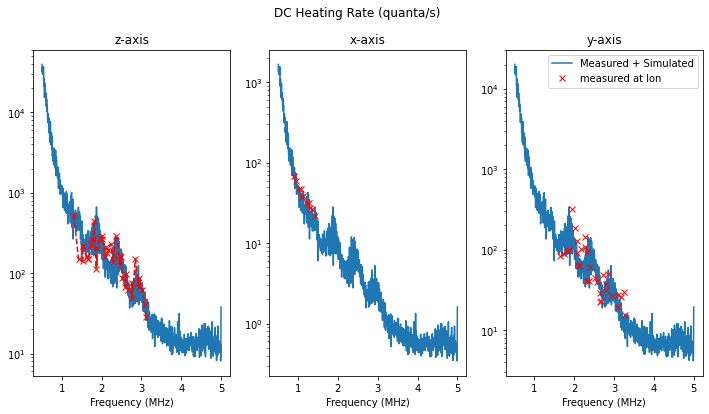

In [211]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


fig1, ax = plt.subplots(1,3, figsize=(12,6))

#ax[0].semilogy(frequency_array_meas, heating_rates_measdac_z, label ='DAC')
#ax[0].semilogy(frequency_array_meas, heating_rates_measfb_noavg_z,label ='DAC + FB instan')
ax[0].semilogy(frequency_array_meas, heating_rates_measfb_z, label ='Measured + Simulated')
ax[0].semilogy(frequency_z, HR_z, label ='measured at Ion', linestyle = '--', marker = 'x', color = 'r')
#ax[0].semilogy(frequency_array_meas, heating_rates_measdac_z ,label ='noise floor')
#ax[0].semilogy(moving_average(frequency_array_meas, 10), moving_average(heating_rates_gnd_meas_z, 10),'+' ,label='Noise Floor')
#ax[0].fill_between(frequency_array_meas, heating_rates_gnd_meas_z,step="pre", alpha=0.4)
ax[0].set_title('z-axis')
#ax[1].semilogy(frequency_array_meas, heating_rates_measdac_x, label ='DAC')
#ax[1].semilogy(frequency_array_meas, heating_rates_measfb_noavg_x,label ='DAC + FB instan')
ax[1].semilogy(frequency_array_meas, heating_rates_measfb_x, label ='Measured + Simulated')
ax[1].semilogy(frequency_x, HR_x, label ='measured at Ion', linestyle = '', marker = 'x', color = 'r')
#ax[1].semilogy(frequency_array_meas, heating_rates_measdac_x, label ='noise floor')
#ax[1].semilogy(moving_average(frequency_array_meas, 10), moving_average(heating_rates_gnd_meas_x, 10),'+' ,label='Noise Floor')
#ax[1].fill_between(frequency_array_meas, heating_rates_gnd_meas_x,step="pre", alpha=0.4)
ax[1].set_title('x-axis')

#ax[2].semilogy(frequency_array_meas, heating_rates_measdac_y, label ='DAC')
#ax[2].semilogy(frequency_array_meas, heating_rates_measfb_noavg_y,label ='DAC + FB instan')
ax[2].semilogy(frequency_array_meas, heating_rates_measfb_y, label ='Measured + Simulated')
ax[2].semilogy(frequency_y, HR_y, label ='measured at Ion', linestyle = '', marker = 'x', color = 'r')
#ax[2].semilogy(moving_average(frequency_array_meas, 10), moving_average(heating_rates_gnd_meas_y, 10),'+' ,label='Noise Floor')
#ax[2].fill_between(frequency_array_meas, heating_rates_gnd_meas_y,step="pre", alpha=0.4)
#ax[2].semilogy(frequency_array_meas, heating_rates_measdac_y,label ='noise floor')
ax[2].set_title('y-axis')

fig1.suptitle('DC Heating Rate (quanta/s)')
for a in ax.flat:
    a.set(xlabel='Frequency (MHz)')
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10**(-6)))
    a.xaxis.set_major_formatter(ticks)


plt.legend()
plt.show()


In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


fig1, ax = plt.subplots(1,3, figsize=(12,6))

ax[0].semilogy(frequency_array_meas, heating_rates_measdac_z, label ='DAC')
ax[0].semilogy(frequency_array_meas, heating_rates_measfb_noavg_z,label ='DAC + FB instan')
#ax[0].semilogy(frequency_array_meas, heating_rates_measfb_z, label ='DAC + FB')
ax[0].semilogy(frequency_z, HR_z, label ='measured at Ion', linestyle = '--', marker = 'x', color = 'r')
#ax[0].semilogy(frequency_array_meas, heating_rates_measdac_z ,label ='noise floor')
ax[0].semilogy(moving_average(frequency_array_meas, 10), moving_average(heating_rates_gnd_meas_z, 10),'+' ,label='Noise Floor')
ax[0].fill_between(frequency_array_meas, heating_rates_gnd_meas_z,step="pre", alpha=0.4)
ax[0].set_title('z-axis')
ax[1].semilogy(frequency_array_meas, heating_rates_measdac_x, label ='DAC')
ax[1].semilogy(frequency_array_meas, heating_rates_measfb_noavg_x,label ='DAC + FB instan')
#ax[1].semilogy(frequency_array_meas, heating_rates_measfb_x, label ='DAC + FB')
ax[1].semilogy(frequency_x, HR_x, label ='measured at Ion', linestyle = '', marker = 'x', color = 'r')
#ax[1].semilogy(frequency_array_meas, heating_rates_measdac_x, label ='noise floor')
ax[1].semilogy(moving_average(frequency_array_meas, 10), moving_average(heating_rates_gnd_meas_x, 10),'+' ,label='Noise Floor')
ax[1].fill_between(frequency_array_meas, heating_rates_gnd_meas_x,step="pre", alpha=0.4)
ax[1].set_title('x-axis')

ax[2].semilogy(frequency_array_meas, heating_rates_measdac_y, label ='DAC')
ax[2].semilogy(frequency_array_meas, heating_rates_measfb_noavg_y,label ='DAC + FB instan')
#ax[2].semilogy(frequency_array_meas, heating_rates_measfb_y, label ='DAC + FB')
ax[2].semilogy(frequency_y, HR_y, label ='measured at Ion', linestyle = '', marker = 'x', color = 'r')
ax[2].semilogy(moving_average(frequency_array_meas, 10), moving_average(heating_rates_gnd_meas_y, 10),'+' ,label='Noise Floor')
ax[2].fill_between(frequency_array_meas, heating_rates_gnd_meas_y,step="pre", alpha=0.4)
#ax[2].semilogy(frequency_array_meas, heating_rates_measdac_y,label ='noise floor')
ax[2].set_title('y-axis')

fig1.suptitle('DC Heating Rate (quanta/Hz)')
for a in ax.flat:
    a.set(xlabel='frequency (MHz)')
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10**(-6)))
    a.xaxis.set_major_formatter(ticks)
    a.set_xlim(1e6, 5e6)


plt.legend()
plt.show()


In [178]:
EF_x = np.array([[ 8.63269344e-03,
 -1.53149734e-03,
 -7.56981354e+01,
 -2.03770309e+02,
  2.59573273e+02,
  5.59090972e-01,
  9.38797355e-01,
 -4.89998360e+01,
  6.66162643e+01,
  1.33121565e-01,
  1.55467704e-01],
[ 9.80981067e-03,
-5.55687526e-04,
 -5.71352234e+01,
 -2.10986374e+02,
  2.52770599e+02,
  5.74955583e-01,
  9.39315856e-01,
 -5.09456177e+01,
  6.40077286e+01,
  1.32143751e-01,
 1.54462576e-01],
 [ 1.53486431e-02,
  4.43163002e-03,
  3.78038559e+01,
 -2.47420441e+02,
  2.16932312e+02,
 6.51601255e-01,
  8.95609319e-01,
 -6.20382957e+01,
  5.25243607e+01,
  1.36211351e-01,
 1.57060057e-01]
 ,[ 1.20223816e-02,
  1.36858330e-03,
 -1.91933136e+01,
 -2.25709061e+02,
  2.38663422e+02,
  5.97980499e-01,
  9.17068124e-01,
 -5.51031761e+01,
  5.91167183e+01,
  1.35113075e-01,
  1.56879306e-01],
[ 1.23287914e-02,
  1.34791445e-03,
 -1.74059315e+01,
 -2.26406494e+02,
  2.38000443e+02,
  5.95255971e-01,
  9.28658009e-01,
 -5.53167953e+01,
  5.88830605e+01,
  1.33842602e-01,
  1.55662194e-01],
[ 1.26567120e-02,
  1.31952111e-03,
 -1.56231413e+01,
 -2.27103668e+02,
  2.37337692e+02,
  5.92566073e-01,
  9.41700161e-01,
 -5.55309448e+01,
  5.86500587e+01,
  1.32331416e-01,
  1.54203966e-01],
[ 1.29658822e-02,
  1.29302952e-03,
 -1.38125629e+01,
 -2.27810059e+02,
  2.36663025e+02,
  5.89341342e-01,
  9.53000844e-01,
 -5.57471962e+01,
  5.84184074e+01,
  1.31164595e-01,
  1.53076142e-01],
[ 1.30830025e-02,
  1.32375432e-03,
 -1.18550959e+01,
 -2.28558502e+02,
  2.35930481e+02,
  5.84538102e-01,
  9.49619591e-01,
 -5.59710884e+01,
  5.81903648e+01,
  1.32545725e-01,
 1.54429913e-01],
[ 1.30969165e-02,
  1.46225363e-03,
 -9.90031719e+00,
 -2.29301483e+02,
  2.35190720e+02,
  5.85882187e-01,
  9.42038178e-01,
 -5.61948318e+01,
  5.79621811e+01,
  1.33704960e-01,
  1.55553445e-01],
[ 1.30749522e-02,
  1.64680555e-03,
 -7.94867754e+00,
 -2.30043839e+02,
  2.34449341e+02,
  5.90020657e-01,
  9.33301151e-01,
 -5.64190292e+01,
  5.77344666e+01,
  1.34631902e-01,
  1.56443879e-01],
[1.30171096e-02,
  1.87740999e-03,
 -6.00017691e+00,
 -2.30785583e+02,
  2.33706345e+02,
  5.96953571e-01,
  9.23408389e-01,
-5.66436882e+01,
  5.75072250e+01,
  1.35326535e-01,
  1.57101214e-01],
[ 1.29233878e-02,
  2.15406716e-03,
 -4.05481625e+00,
 -2.31526703e+02,
 2.32961716e+02,
 6.06680870e-01,
  9.12360013e-01,
 -5.68688011e+01,
  5.72804527e+01,
  1.35788858e-01,
 1.57525435e-01,],
[1.27937887e-02,
  2.47677695e-03,
 -2.11259508e+00,
 -2.32267197e+02,
  2.32215454e+02,
  6.19202554e-01,
  9.00155902e-01,
 -5.70943756e+01,
  5.70541496e+01,
  1.36018887e-01,
  1.57716572e-01],
[ 1.26283104e-02,
  2.84553925e-03,
 -1.73513234e-01,
 -2.33007065e+02,
  2.31467575e+02,
  6.34518683e-01,
  8.86796176e-01,
 -5.73204041e+01,
 5.68283157e+01,
  1.36016592e-01,
 1.57674611e-01],
[ 1.24269547e-02,
  3.26035428e-03,
  1.76242900e+00,
-2.33746307e+02,
  2.30718063e+02,
  6.52629197e-01,
  8.72280717e-01,
 -5.75468903e+01,
  5.66029510e+01,
  1.35782003e-01,
  1.57399550e-01],
[1.21897198e-02,
  3.72122182e-03,
  3.69523191e+00,
 -2.34484940e+02,
  2.29966934e+02,
  6.73534095e-01,
  8.56609643e-01,
 -5.77738342e+01,
  5.63780594e+01,
  1.35315120e-01,
  1.56891391e-01],
[1.19166067e-02,
  4.22814209e-03,
  5.62489510e+00,
 -2.35222946e+02,
  2.29214188e+02,
  6.97233438e-01,
  8.39782894e-01,
 -5.80012321e+01,
  5.61536369e+01,
  1.34615913e-01,
  1.56150132e-01],
[1.19095165e-02,
  4.50879754e-03,
  7.50133085e+00,
 -2.35942337e+02,
  2.28488815e+02,
  7.09546447e-01,
  8.35779727e-01,
 -5.82291031e+01,
  5.59315834e+01,
  1.33502916e-01,
  1.55030787e-01],
[ 1.22614410e-02,
  4.43491479e-03,
  9.34100151e+00,
 -2.36648788e+02,
  2.27791046e+02,
  7.03351855e-01,
  8.47716331e-01,
 -5.84569855e+01,
  5.57111053e+01,
 1.32623926e-01,
 1.54162869e-01],
[1.30490568e-02,
  3.85076157e-03,
  1.12047596e+01,
-2.37365158e+02,
 2.27104721e+02,
 6.69943631e-01,
  8.77095699e-01,
 -5.86840172e+01,
  5.54896126e+01,
  1.33246139e-01,
  1.54764503e-01],
[ 1.36801414e-02,
  3.39148659e-03,
  1.30639400e+01,
 -2.38075333e+02,
  2.26422775e+02,
  6.42327607e-01,
  8.98575962e-01,
 -5.89108696e+01,
  5.52682877e+01,
  1.34303451e-01,
  1.55789524e-01],
[ 1.38831949e-02,
  3.33333854e-03,
  1.50282583e+01,
 -2.38813522e+02,
  2.25673401e+02,
  6.33932173e-01,
  8.99139583e-01,
 -5.91480789e+01,
 5.50528755e+01,
  1.35697246e-01,
 1.57131091e-01],
[ 1.40844909e-02,
  3.27873253e-03,
  1.70007324e+01,
 -2.39554108e+02,
  2.24918732e+02,
  6.25599980e-01,
  8.99585128e-01,
 -5.93866844e+01,
  5.48384171e+01,
  1.37080580e-01,
  1.58465236e-01],
[ 1.43210748e-02,
  3.19174863e-03,
  1.89700928e+01,
 -2.40293808e+02,
  2.24166061e+02,
  6.15593314e-01,
 9.01706636e-01,
-5.96256256e+01,
  5.46243324e+01,
  1.38442248e-01,
  1.59782395e-01],[ 1.03180800e-02,
  1.06235035e-03,
 -3.84970818e+01,
 -2.18286728e+02,
  2.45979477e+02,
  6.17876947e-01,
  9.00667131e-01,
 -5.29625359e+01,
  6.14973869e+01,
  1.32902011e-01,
  1.54986590e-01],
[ 1.53486431e-02,
  4.43163002e-03,
  3.78038559e+01,
 -2.47420441e+02,
  2.16932312e+02,
  6.51601255e-01,
  8.95609319e-01,
 -6.20382957e+01,
  5.25243607e+01,
  1.36211351e-01,
  1.57060057e-01],
[ 1.59982704e-02,
 5.81449317e-03,
  5.67749977e+01,
 -2.54512512e+02,
  2.09627380e+02,
  6.83391631e-01,
  8.66985619e-01,
 -6.45669632e+01,
  5.05116653e+01,
  1.38207778e-01,
  1.58895150e-01]])

[52.55145339240784, 51.20840050385985, 50.320696250134766, 49.667914033226495, 49.637595159150266, 49.61104647242189, 49.587347469925746, 49.562919883006145, 49.54030101883131, 49.52164297542826, 49.50693515624859, 49.496157511344315, 49.48929620554314, 49.4863403205465, 49.4872731239627, 49.49208780828291, 49.50076675563567, 49.51512292321274, 49.536086117068244, 49.5653425125873, 49.59807082125485, 49.62950469675219, 49.66502671502416, 49.705159193781135, 50.28208638145362, 50.320696250134766, 51.33770510623589]


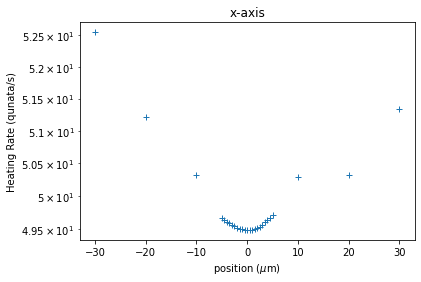

In [180]:
#Heating rate x-axis vs position from -0.5 to 0.5um
HR_pos = []
#x = np.arange(-5,5.5,0.5)
x =[-30.,-20. ,-10. ,-5. , -4.5, -4. , -3.5, -3. , -2.5 ,-2.,  -1.5 ,-1.  ,-0.5, 0.  , 0.5 , 1.  , 1.5,
  2.  , 2.5,  3.,   3.5 , 4.  , 4.5 , 5.,10.,20.,30.]

## conversion
def SEcalc1axs1elec(Volt_sd, V_E_scaling):
    return Volt_sd *(V_E_scaling)**(2)

for i in range(len(EF_x)):
    x_val = 0

    for j in range(11):
         x_val += SEcalc1axs1elec(fb_noise[110],EF_x[i,j])
    HR_x =((cons.e)**2 * x_val)/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[110])
    HR_pos.append(HR_x)


print(HR_pos)

figure, ax = plt.subplots()

ax.semilogy(x, HR_pos, '+' )
ax.set_xlabel('position ($\mu$m)')
ax.set_ylabel('Heating Rate (qunata/s)')
ax.set_title('x-axis')
plt.show()


In [167]:
displfiv = [ 1.39554646e-02, 
2.26811110e-03,
 9.21717834e+00,
 -2.31340317e+02,
2.22746826e+02,
  5.82507670e-01,
  9.00376797e-01,
 -5.84653015e+01,
  5.57259026e+01,
  1.36642665e-01,
 1.58524990e-01]

x_1 = 0
for i in range(11):
    x_1 += SEcalc1axs1elec(fb_noise[110],displfiv[i])
HR_x =((cons.e)**2 * x_1)/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[110])


print(HR_x)

47.478231508646545


In [172]:
x = np.arange(-5,5.5,0.5)
print(x)

[-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5
  2.   2.5  3.   3.5  4.   4.5  5. ]


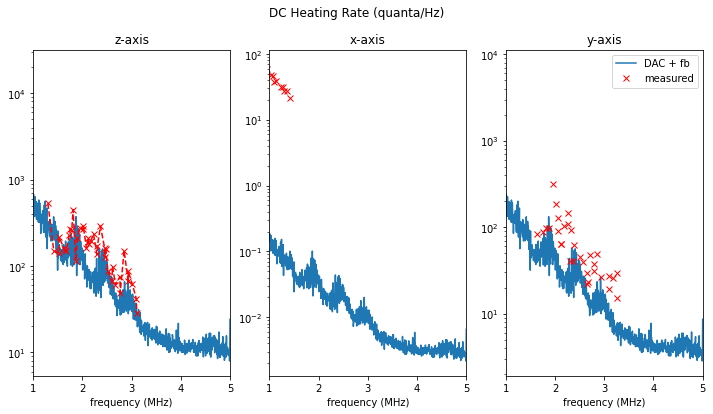

In [326]:
#WRONG
SE_meas_z = []
heating_rates_meas_z = []
SE_meas_x = []
heating_rates_meas_x = []
SE_meas_y = []
heating_rates_meas_y = []


SE_measfb_z = []
heating_rates_measfb_z = []
SE_measfb_x = []
heating_rates_measfb_x = []
SE_measfb_y = []
heating_rates_measfb_y = []


SE_measdac_z = []
heating_rates_measdac_z = []
SE_measdac_x = []
heating_rates_measdac_x = []
SE_measdac_y = []
heating_rates_measdac_y = []


## conversion
def SEcalc1axs1elec(Volt_sd, V_E_scaling, Voltage):
    return Volt_sd * (V_E_scaling)**(2) /((Voltage)**(2))

for i in range(0, len(frequency_array_meas)):
    z_summe_ch = 0
    z_summe_fb = 0
    z_summe_dac= 0

    x_summe_ch = 0
    x_summe_fb = 0
    x_summe_dac= 0

    y_summe_ch = 0
    y_summe_fb = 0
    y_summe_dac= 0



    for j in range(len(z_axis)):
        z_summe_ch += SEcalc1axs1elec(chasis_noise[i],z_axis[j],Voltage_Set[j])
        z_summe_fb += SEcalc1axs1elec(fb_noise[i],z_axis[j],Voltage_Set[j])
        z_summe_dac += SEcalc1axs1elec(Dac_noise[i],z_axis[j],Voltage_Set[j])
        #firstelec = SEcalc1axs1elec(Noise[i],y_axis[4]) + SEcalc1axs1elec(Noise[i],y_axis[5]) + SEcalc1axs1elec(Noise[i],y_axis[6])

        x_summe_ch += SEcalc1axs1elec(chasis_noise[i],x_axis[j],Voltage_Set[j])
        x_summe_fb += SEcalc1axs1elec(fb_noise[i],x_axis[j],Voltage_Set[j])
        x_summe_dac += SEcalc1axs1elec(Dac_noise[i],x_axis[j],Voltage_Set[j])

        y_summe_ch += SEcalc1axs1elec(chasis_noise[i],y_axis[j],Voltage_Set[j])
        y_summe_fb += SEcalc1axs1elec(fb_noise[i],y_axis[j],Voltage_Set[j])
        y_summe_dac += SEcalc1axs1elec(Dac_noise[i],y_axis[j],Voltage_Set[j])


    SE_meas_z.append(z_summe_ch)
    SE_meas_x.append(x_summe_ch)  
    SE_meas_y.append(y_summe_ch)   

    SE_measfb_z.append(z_summe_fb)
    SE_measfb_x.append(x_summe_fb)  
    SE_measfb_y.append(y_summe_fb)     

    SE_measdac_z.append(z_summe_dac)
    SE_measdac_x.append(x_summe_dac)  
    SE_measdac_y.append(y_summe_dac)      


for k in range(0, len(frequency_array_meas)):

    heating_meas_z = ((cons.e)**2 * SE_meas_z[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heating_meas_x = ((cons.e)**2 * SE_meas_x[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heating_meas_y = ((cons.e)**2 * SE_meas_y[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])


    heatingfb_meas_z = ((cons.e)**2 * SE_measfb_z[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatingfb_meas_x = ((cons.e)**2 * SE_measfb_x[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatingfb_meas_y = ((cons.e)**2 * SE_measfb_y[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])

    heatingdac_meas_z = ((cons.e)**2 * SE_measdac_z[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatingdac_meas_x = ((cons.e)**2 * SE_measdac_x[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatingdac_meas_y = ((cons.e)**2 * SE_measdac_y[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])


    heating_rates_meas_z.append(heating_meas_z)
    heating_rates_meas_x.append(heating_meas_x)
    heating_rates_meas_y.append(heating_meas_y)

    heating_rates_measfb_z.append(heatingfb_meas_z)
    heating_rates_measfb_x.append(heatingfb_meas_x)
    heating_rates_measfb_y.append(heatingfb_meas_y)

    heating_rates_measdac_z.append(heatingdac_meas_z)
    heating_rates_measdac_x.append(heatingdac_meas_x)
    heating_rates_measdac_y.append(heatingdac_meas_y)

## Plotting Data 

fig, ax = plt.subplots(1,3, figsize=(12,6))

#ax[0].semilogy(frequency_array_meas, heating_rates_meas_z, label ='DAC + fb grounded')
ax[0].semilogy(frequency_array_meas, heating_rates_measfb_z, label ='DAC + fb')
ax[0].semilogy(frequency_z, HR_z, label ='measured', linestyle = '--', marker = 'x', color = 'r')
#ax[0].semilogy(frequency_array_meas, heating_rates_measdac_z, label ='DAC + sim')
ax[0].set_title('z-axis')
#ax[1].semilogy(frequency_array_meas, heating_rates_meas_x, label ='DAC + fb grounded')
ax[1].semilogy(frequency_array_meas, heating_rates_measfb_x, label ='DAC + fb')
ax[1].semilogy(frequency_x, HR_x, label ='measured', linestyle = '', marker = 'x', color = 'r')
#ax[1].semilogy(frequency_array_meas, heating_rates_measdac_x, label ='DAC + sim')
ax[1].set_title('x-axis')

#ax[2].semilogy(frequency_array_meas, heating_rates_meas_y, label ='DAC + fb grounded')
ax[2].semilogy(frequency_array_meas, heating_rates_measfb_y, label ='DAC + fb')
ax[2].semilogy(frequency_y, HR_y, label ='measured', linestyle = '', marker = 'x', color = 'r')
#ax[2].semilogy(frequency_array_meas, heating_rates_measdac_y, label ='DAC + sim')
ax[2].set_title('y-axis')

fig.suptitle('DC Heating Rate (quanta/Hz)')
for a in ax.flat:
    a.set(xlabel='frequency (MHz)')
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10**(-6)))
    a.xaxis.set_major_formatter(ticks)
    a.set_xlim(1e6, 5e6)


plt.legend()
plt.show()

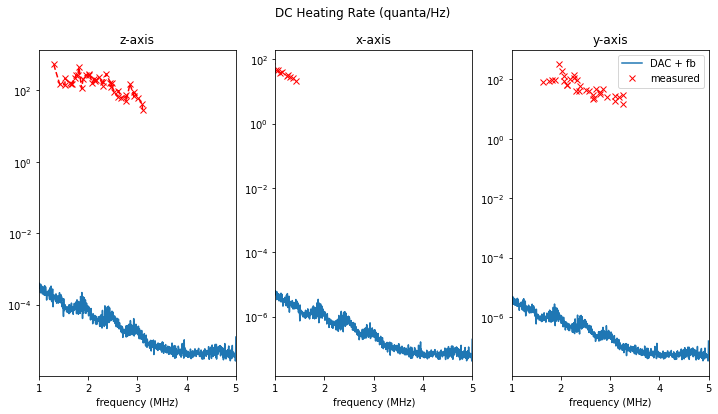

In [151]:
SE_meas_z = []
heating_rates_meas_z = []
SE_meas_x = []
heating_rates_meas_x = []
SE_meas_y = []
heating_rates_meas_y = []

scale = [-0.37461139,  0.33546076 ,-2.99145794]


def SEcalc1axs1elec(Volt_sd, V_E_scaling):
    return Volt_sd * (V_E_scaling)**(2)

for i in range(0, len(frequency_array_meas)):

        z = SEcalc1axs1elec(fb_noise[i],scale[2])
        x = SEcalc1axs1elec(fb_noise[i],scale[0])
        y = SEcalc1axs1elec(fb_noise[i],scale[1])

        SE_meas_z.append(z)
        SE_meas_x.append(x)
        SE_meas_y.append(y)

for k in range(0, len(frequency_array_meas)):

    heatingz = ((cons.e)**2 * SE_meas_z[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatingx = ((cons.e)**2 * SE_meas_x[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatingy = ((cons.e)**2 * SE_meas_y[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])



    heating_rates_meas_z.append(heatingz)
    heating_rates_meas_x.append(heatingx)
    heating_rates_meas_y.append(heatingy)





fig, ax = plt.subplots(1,3, figsize=(12,6))


ax[0].semilogy(frequency_array_meas, heating_rates_meas_z, label ='DAC + fb')
ax[0].semilogy(frequency_z, HR_z, label ='measured', linestyle = '--', marker = 'x', color = 'r')

ax[0].set_title('z-axis')

ax[1].semilogy(frequency_array_meas, heating_rates_meas_x, label ='DAC + fb')
ax[1].semilogy(frequency_x, HR_x, label ='measured', linestyle = '', marker = 'x', color = 'r')

ax[1].set_title('x-axis')


ax[2].semilogy(frequency_array_meas, heating_rates_meas_y, label ='DAC + fb')
ax[2].semilogy(frequency_y, HR_y, label ='measured', linestyle = '', marker = 'x', color = 'r')
ax[2].set_title('y-axis')

fig.suptitle('DC Heating Rate (quanta/Hz)')
for a in ax.flat:
    a.set(xlabel='frequency (MHz)')
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10**(-6)))
    a.xaxis.set_major_formatter(ticks)
    a.set_xlim(1e6, 5e6)


plt.legend()
plt.show()

In [18]:
frequency_x = np.array([0.9001789823391073,
0.9437795729477444,
1.0252114885676957,
1.0638987887232565,
1.100821295451343,
1.135977488147777,
1.236995745603602,
1.267927434665372,
1.2996137379209354,
1.3586571602600996,
1.415701554619007])
HR_x = [69.24038869733933,
59.96234042377333,
47.2138851604604,
46.87063426697047,
37.475966505562255,
39.00563001250567,
31.281636157386867,
31.808799176921827,
27.730829872254766,
26.928522292376087,
21.589198655440015]
frequency_y =np.array([1.636717664073176,
1.7536338634632855,
1.8203482753879003,
1.8779897626938327,
1.9564506050049877,
2.017706938996064,
2.059106057300692,
2.0685732477088816,
2.1263569835276694,
2.131024608733191,
2.1777966511759748,
2.2606404448466964,
2.264803303855524,
2.3094745527924125,
2.3281001503012906,
2.36837062575528,
2.3849040793683076,
2.510028803327298,
2.5699035468931064,
2.6503880938410074,
2.656269565447679,
2.676090733502241,
2.712717466840009,
2.786931815957286,
2.8008107026471483,
2.8546191443380193,
2.941854418671944,
3.1005188732475477,
3.1030324705203385,
3.1775296269353306,
3.258474391947965,
3.2683624563390397])
HR_y = [83.1316978538842,
87.1181096291914,
96.74398456185432,
98.05476403643297,
317.32366620027733,
184.53757871196763,
89.84257107969407,
127.15788475447035,
63.53830073478075,
63.643521576931846,
101.92438891901317,
144.53381830750342,
108.79548718749002,
40.88811015418392,
93.67572781724047,
40.6244462378223,
61.72556842189231,
44.93652605958764,
39.547346977122494,
29.256747851191978,
22.094067716037976,
23.018262555123087,
47.767145589454685,
31.405541907047905,
37.38933429187226,
49.175929249922696,
26.369913258807475,
27.22494199890959,
19.151001987434437,
25.57834629527803,
29.89083016253065,
15.238538324671833]
frequency_z = [ 1.3006531228324631,
1.4219998106805296,
1.528808904028959,
1.529038593885789,
1.6222867469610052,
1.6526144143251333,
1.6716286167317251,
1.7354391725138367,
1.7534472255609748,
1.7862289383704435,
1.813798119863976,
1.8661076549427857,
1.8976857082214083,
1.9511326528103774,
2.014522358507832,
2.018349014787159,
2.085631569092366,
2.1197646193723507,
2.143368791558399,
2.167159695408431,
2.22902072210736,
2.299057617348615,
2.3062992387009165,
2.3691792467435486,
2.4523265691277363,
2.4598293211825086,
2.4784592798352842,
2.5201431695313983,
2.5996644217703304,
2.614229943490361,
2.674374926568465,
2.763042218359706,
2.7706925100325894,
2.849412255065737,
2.931007955353169,
2.931931383238576,
3.0122735535852994,
3.0964691255211214,
3.1060919441834898 ]
HR_z = [530.1174631931104,
148.96534086729986,
142.1574966038835,
215.66264929298882,
162.80523487069573,
151.43439004659754,
149.82375034292608,
225.8380211737235,
268.3532552385673,
261.4922082743787,
448.10381245925356,
114.14022557165268,
207.96595022296438,
271.6804507964738,
265.81229657232694,
291.2934618390539,
159.80109896106026,
209.86404562850345,
178.04778145324485,
192.28289681582436,
231.68656211013186,
136.27946983090325,
168.7843622674747,
288.9218416924599,
162.87755055013187,
127.74672490746997,
158.21131280390307,
87.3006801872009,
66.6793027541329,
97.72298669444105,
61.037860461430995,
75.01722966537993,
49.0495081906319,
150.88086399682203,
67.6944393534121,
87.19541684492229,
62.67221240699694,
41.830974475958676,
28.328439593766962]

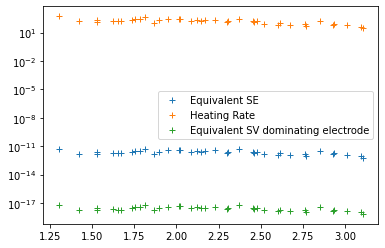

In [98]:
def SE(HR,w):
    return (4*m_Ca*cons.hbar*2*np.pi*w*10**(6)*HR)/(cons.e)**2
def SV(HR,w): 
     SE = (4*m_Ca*cons.hbar*2*np.pi*w*10**(6)*HR)/(cons.e)**2
     return SE/((z_axis[10])**(2))
        

SE_equiv = [] 
SV_equiv = []

for i in range(0,len(frequency_z)): 
    SE_equiv.append(SE(HR_z[i],frequency_z[i]))
    SV_equiv.append(SV(HR_z[i],frequency_z[i]))


plt.plot(frequency_z, SE_equiv, '+', label='Equivalent SE')
plt.plot(frequency_z, HR_z, '+', label='Heating Rate')
plt.plot(frequency_z, SV_equiv , '+', label='Equivalent SV dominating electrode')
ax.set_xlabel('frequency (MHz)')
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10**(-6)))
ax.xaxis.set_major_formatter(ticks)
plt.yscale('log',base=10) 
plt.legend()
plt.show()